# Analysis of Steinmetz Neuropixels recordings of spontaneous activity (Week 1-2)

## Background
---
The dataset under investigation contains the Neuropixel recordings of three mice during periods of spontaneous behaviors. The original data follows the standardized ONE (Open Neurophysiology Evironment) format proposed by the International Brain Laboratory. The core of the dataset consists of several of the ONE dataset types: spikes.times, spikes.clusters, spikes.depths and so on. As they are, the data items do not allow for easy analysis and, thus, needed preprocessing. This was achieved through matlab and the structure of the resulting data is elaborated in the next section. Below is an illustration of the configuration of the Neuropixel probes.

## Structure
---
The data for each of the three mice is stored in a .mat file which contains several variables corresponding to different components:
- `areaLabels` list of abbreviated strings for different brain areas
- `brainLoc` array of indexes corresponding to brain areas in `areaLabels`
- `iprobe` array of probes number/ID
- `miceNames` list of mice names
- `mostSVD` svd components of movie frames of mouse face during recording 
- `srate` sampling rate (for scaling spike time so that \(\Delta t=1\))
- `stall` matrix of spike train for all neurons during spontaneous activity
- `tspont` spontaneous period (array of time)
- `tVid` times of movie frames in spike reference frame
- `Wh` array of relative heights of the neurons

## Analysis
---

In [1]:
using Plots; gr()
using MAT
using Printf
using LinearAlgebra
using Statistics
using BenchmarkTools

### Load Data

In [2]:
# Load all data in a three-element array of dictionaries
# Each element corresponding to each mouse maps variable names to their values  
mice_names = ["Krebs", "Robbins", "Waksman"]
data = [MAT.matread("./Data/$(mice_names[i])withFaces_KS2.mat") for i in 1:3];

LoadError: File "./Data/KrebswithFaces_KS2.mat" does not exist and create was not specified

### Visualize Spike Train

In [1]:
function displaySpikeTrain(data)
    p1 = heatmap(data[1]["stall"], clim=(0, 1), title="Krebs")
    p2 = heatmap(data[2]["stall"], clim=(0, 1), title="Robbins")
    p3 = heatmap(data[3]["stall"], clim=(0, 1), title="Waksman")
    plot(p1, p2, p3, xlabel="Time", ylabel="Neuron",
        layout=(3, 1), size=(1200, 900))
end

displaySpikeTrain (generic function with 1 method)

In [7]:
displaySpikeTrain(data)

### Data Distribution

In [3]:
function dataDist(dt, dttype)
    # neuron distribution w.r.t. height on probe
    if dttype == "height"
        p1 = histogram(dt[1]["Wh"], nbin=:rice, title="Krebs")
        p2 = histogram(dt[2]["Wh"], nbin=:rice, title="Robbins")
        p3 = histogram(dt[3]["Wh"], nbin=:rice, title="Krebs")
        plot(p1, p2, p3, xlabel="Height on probe", yaxis=("Number of neurons", (0, 300)),
            guidefontsize=10, layout=(1, 3), size=(900, 400), grid=false, legend=false)
        
    # neuron distribution w.r.t. brain area    
    elseif dttype == "area"
        p1 = histogram(dt[1]["brainLoc"], nbin=1:15, title="Krebs")
        p2 = histogram(dt[2]["brainLoc"], nbin=1:15, title="Robbins")
        p3 = histogram(dt[3]["brainLoc"], nbin=1:15, title="Waksman")
        plot(p1, p2, p3, xticks=(1:14, vec(data[1]["areaLabels"])), xrotation=90, xlabel="Brain region", yaxis=("Number of neurons", (0, 2000)),
            guidefontsize=10, layout=(1, 3), size=(900, 400), grid=false, legend=false)
    
    # neuron distribution w.r.t. probes
    elseif dttype == "probe"
        p1 = histogram(dt[1]["iprobe"], nbin=8, title="Krebs")
        p2 = histogram(dt[2]["iprobe"], nbin=8, title="Robbins")
        p3 = histogram(dt[3]["iprobe"], nbin=8, title="Waksman")
        plot(p1, p2, p3, xlabel="Probe", yaxis=("Number of neurons", (0, 700)),
            guidefontsize=10, layout=(1, 3), size=(900, 400), grid=false, legend=false)
    
    # neuron distribution w.r.t. firing rates
    elseif dttype == "rate"
        p1 = histogram(sum(dt[1]["stall"], dims=2)/(dt[1]["tspont"][end]-dt[1]["tspont"][1]), nbin=18, title="Krebs")
        p2 = histogram(sum(dt[2]["stall"], dims=2)/(dt[2]["tspont"][end]-dt[2]["tspont"][1]), nbin=18, title="Robbins")
        p3 = histogram(sum(dt[3]["stall"], dims=2)/(dt[3]["tspont"][end]-dt[3]["tspont"][1]), nbin=18, title="Waksman")
        plot(p1, p2, p3, xaxis=("Firing Rate", (0, 100)), yaxis=("Number of neurons", (0, 1000)),
            guidefontsize=10, layout=(1, 3), size=(900, 400), grid=false, legend=false)
    end
end

dataDist (generic function with 1 method)

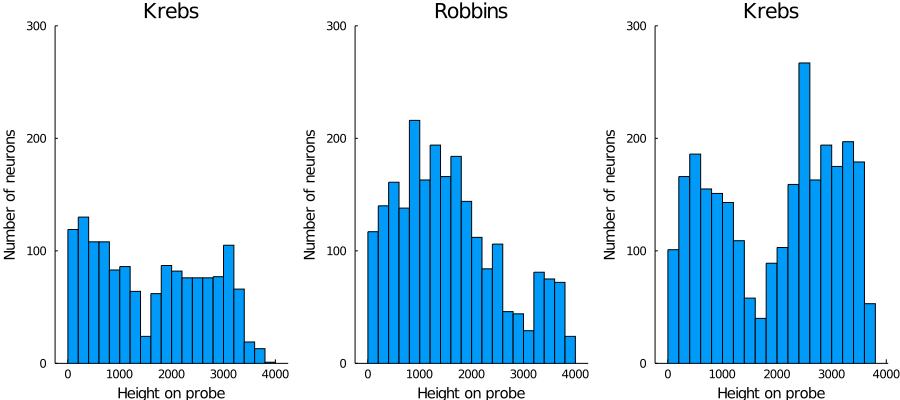

In [183]:
dataDist(data, "height")

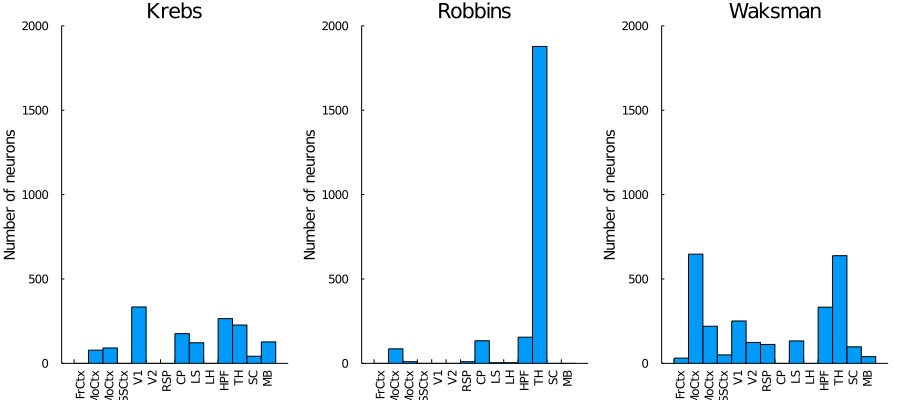

In [4]:
dataDist(data, "area")

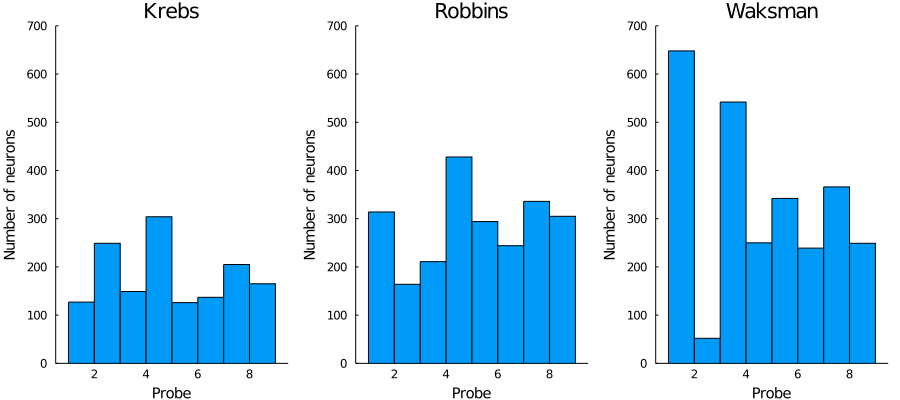

In [143]:
dataDist(data, "probe")

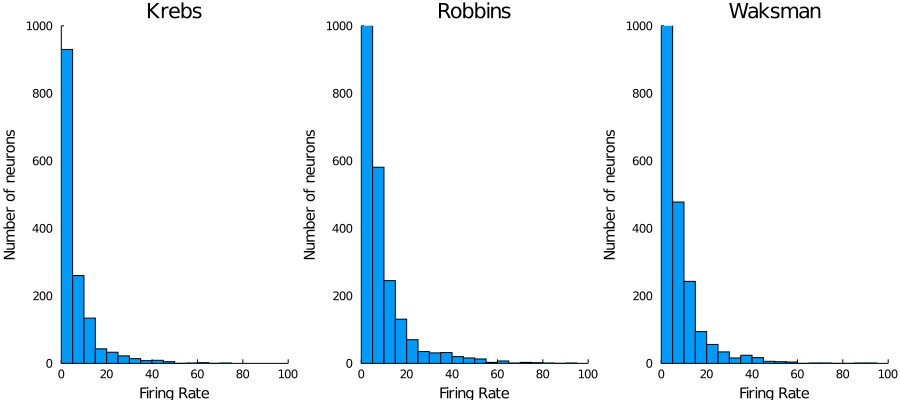

In [237]:
dataDist(data, "rate")

### Data Correlation

In [4]:
function correlation(x1, x2)
    μ1 = mean(x1); μ2 = mean(x2)
    σ1 = std(x1, corrected=false); σ2 = std(x2, corrected=false)
    cov = dot(x1 - fill(μ1, size(x1)), x2 - fill(μ2, size(x2))) / length(x1)
    
    return cov/(σ1*σ2)
end

correlation (generic function with 1 method)

In [4]:
function correlRateNLoc(data, names)
    println("Probe\t\t1\t2\t3\t4\t5\t6\t7\t8\t")
    for i = 1:3
        duration = data[i]["tspont"][end] - data[i]["tspont"][1]
        frates = sum(data[i]["stall"], dims=2)/duration
        print("$(names[i])\t\t")
        for j = 1:8
            idx = @. data[i]["iprobe"] == j
            corr = correlation(frates[idx], data[i]["Wh"][idx])
            @printf("%.2f\t", corr)
        end
        println()
    end
end

correlRateNLoc (generic function with 1 method)

In [5]:
correlRateNLoc(data, mice_names)

Probe		1	2	3	4	5	6	7	8	
Krebs		0.11	0.19	-0.05	-0.10	0.06	-0.16	-0.35	-0.36	
Robbins		0.12	-0.10	0.17	-0.16	-0.24	-0.52	0.04	-0.07	
Waksman		-0.13	0.06	-0.13	-0.08	-0.07	-0.09	-0.32	-0.24	


In [6]:
function correlSpike(dt, names)
    N_neurons = length(data[1]["Wh"])
    pls = Array{Plots.Plot{Plots.GRBackend}}(undef, 3)
    corrMat = Array{Float64}(undef, N_neurons, N_neurons)
    
    for i = 1
        spike_train = dt[i]["stall"]
        for j = 1:N_neurons
            for k = 1:N_neurons
                corrMat[j, k] = correlation(spike_train[j, :], spike_train[k, :])
            end
        end
        pls[i] = heatmap(corrMat, clim=(-1, 1), title=names[i])
    end
    
    plot(pls[1])#, pls[2], pls[3])
end

correlSpike (generic function with 1 method)

In [ ]:
correlSpike(data, mice_names)

In [77]:
function t1(a, ll, ul)
    #output = @. a[ll < a < ul]
    output = findall(x->ll<x<ul, a)
    return a[output]
end

t1 (generic function with 1 method)

In [78]:
@btime t1(c, 10, 20)

  185.501 ns (8 allocations: 432 bytes)


1-element Array{Float64,1}:
 15.0

In [6]:
x = [-7, 8, -10, 5]
y = [-2, 7, -11, 0]
x_ = (x - fill(mean(x), size(x))) / std(x, corrected=false)
y_ = (y - fill(mean(y), size(y))) / std(y, corrected=false)
dot(x_, y_)/4

0.8855219840010659

In [5]:
correlation(x, y)

0.8855219840010659

In [8]:
dot(x, y)/(norm(x, 2) * norm(y, 2))

0.8845235543978212

In [9]:
norm(x-y, 2)

7.211102550927978